In [3]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ev2gym.models.ev2gym_env import EV2Gym

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller

import gurobipy as gp
from gurobipy import GRB
from gurobipy import *

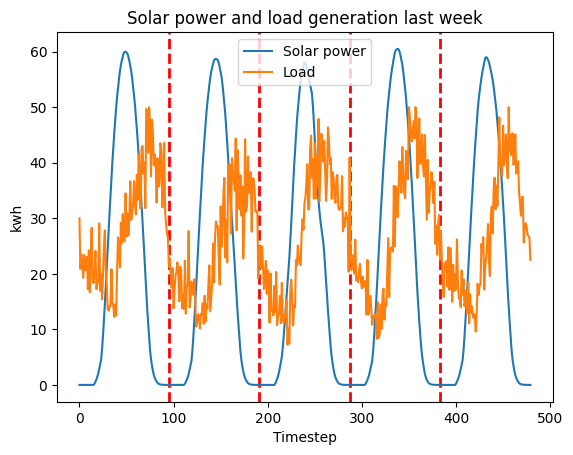

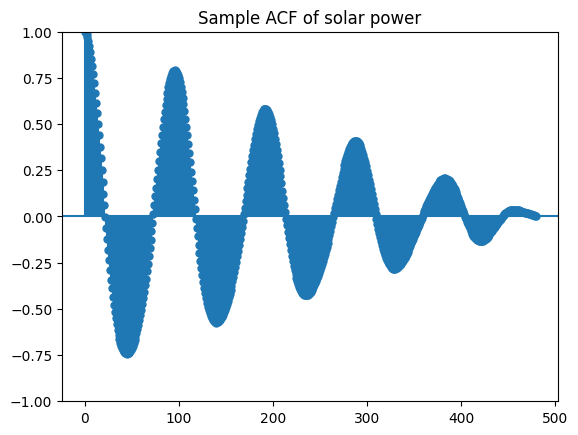

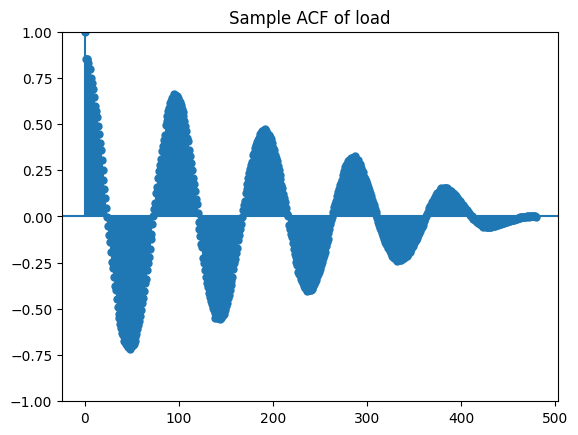

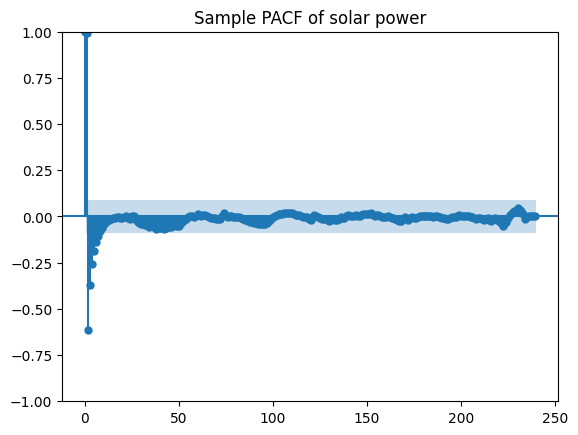

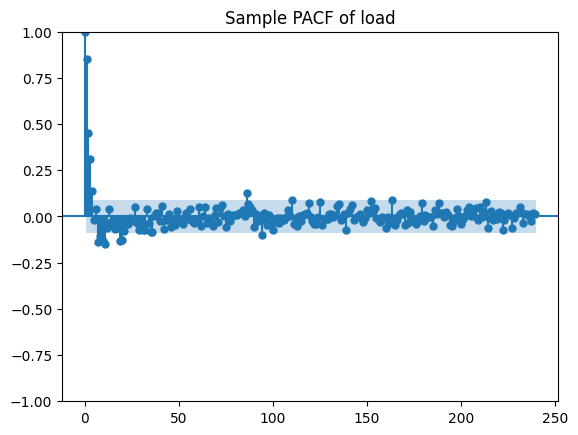

In [4]:
# Use Time series to forecast the solar power and load for the next 24 hours
# I will use SARIMA model for this purpose

df = pd.read_csv('data_for_forecast.csv')
n = len(df)
one_day_n = int(n / 5)  # seasonal period

# plot red dashed line to indicate a change of day
for i in range(1,5):
    plt.axvline(one_day_n * i - 1, color='r', linestyle='--', linewidth=2)

plt.title("Solar power and load generation last week")
plt.plot(range(n), df['solar_power'], label="Solar power")
plt.plot(range(n), df['load'], label = "Load")
plt.xlabel("Timestep")
plt.ylabel("kwh")
plt.legend()

plot_acf(df['solar_power'], lags=n-1, title="Sample ACF of solar power", alpha=None);
plot_acf(df['load'], lags=n-1, title="Sample ACF of load", alpha=None);

plot_pacf(df['solar_power'], lags=(n-1)/2, title="Sample PACF of solar power");
plot_pacf(df['load'], lags=(n-1)/2, title="Sample PACF of load");



In [5]:
# Check for stationarity

adf_solar_power = adfuller(df['solar_power'])
print("Result of ADF for solar power:", adf_solar_power)

adf_load = adfuller(df['load'])
print("Result of ADF for load:", adf_load)


Result of ADF for solar power: (-5.792847524796563, 4.827179562596161e-07, 6, 473, {'1%': -3.444250937448703, '5%': -2.867669873870454, '10%': -2.5700349866579657}, -324.43277598735847)
Result of ADF for load: (-5.174308028399118, 9.918435605749972e-06, 18, 461, {'1%': -3.4446148284445153, '5%': -2.8678299626609314, '10%': -2.5701203107928157}, 2715.7454495992633)


## Comment
Seems like based on the ADF above, the time series for solar power and load are stationary.

Judging from the ACF, solar power and load seems to be made of AR (because of die-off ACF).

Judging from PACF, solar power seems to have AR with p = 5, but no seasonal AR.
Load seems to have AR with p = 4, and a seasonal AR with P = 1.


                               SARIMAX Results                                
Dep. Variable:            solar_power   No. Observations:                  480
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 165.226
Date:                Wed, 04 Dec 2024   AIC                           -316.452
Time:                        16:56:55   BIC                           -287.236
Sample:                             0   HQIC                          -304.968
                                - 480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8138      3.939      5.285      0.000      13.094      28.533
ar.L1          2.4743      0.103     23.912      0.000       2.271       2.677
ar.L2         -2.0023      0.283     -7.084      0.0

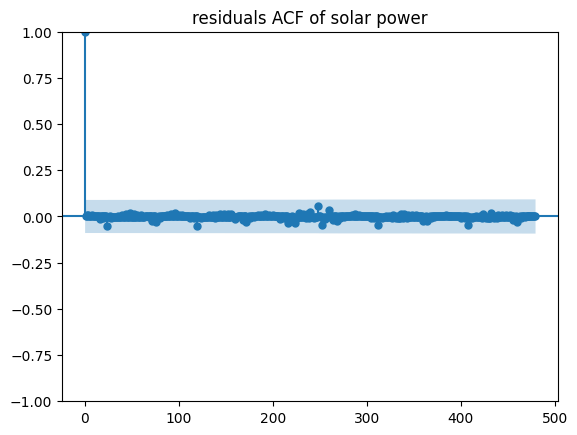

In [6]:
# ARIMA solar
ARIMA_solar = ARIMA(df['solar_power'], order= (5, 0, 0)).fit()

print(ARIMA_solar.summary())

plot_acf(ARIMA_solar.resid, lags= len(ARIMA_solar.resid)-1, title="residuals ACF of solar power");

## Comment
Judging from the residual ACF, the model ARIMA(5,0,0) works well for solar power

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  480
Model:             SARIMAX(4, 0, 0)x(1, 0, 0, 96)   Log Likelihood               -1423.776
Date:                            Wed, 04 Dec 2024   AIC                           2859.551
Time:                                    16:57:11   BIC                           2884.594
Sample:                                         0   HQIC                          2869.395
                                            - 480                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.044      6.123      0.000       0.183       0.355
ar.L2          0.2736      0.047   

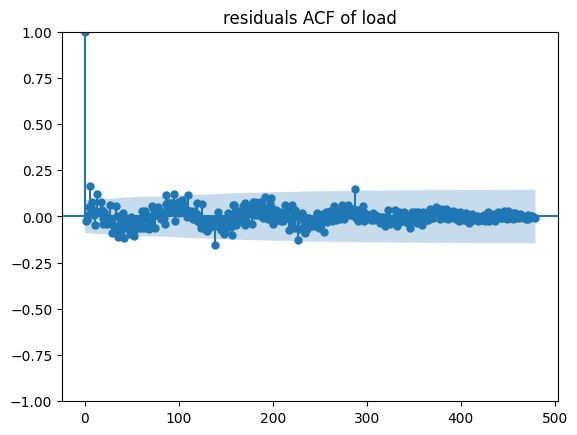

In [7]:
# SARIMA load

SARIMA_load = SARIMAX(df['load'], order = (4,0,0), seasonal_order=(1,0,0,one_day_n)).fit()
print(SARIMA_load.summary())

plot_acf(SARIMA_load.resid, lags= len(SARIMA_load.resid)-1, title="residuals ACF of load");


## Comment
the residual ACF might not seem to be the best, but I can't seem to find a better model than the above for the load

In [ ]:
# NOTE THIS SIMULATION ASSUME 1 CS ONLY HAS 1 PORT
# ALSO ONLY HAS 1 TRANSFORMER IN WHICH IT ACTS LIKE A GRID IN THIS SIMULATION

# optimization agent

# also I do want to point out that when the EV departure time == current timestep, then it wont charge/discharge anymore.

class MySolution:
    def __init__(self, env, debug, load_model, solar_power_model, control_horizon= 96): #96 timesteps == 24 hours, because 15 minutes per timestep
        self.env = env
        self.control_horizon = control_horizon
        self.load_model = load_model
        self.solar_power_model = solar_power_model
        self.debug = debug

        global forecast_solar_0, forecast_load_0, soc_evs

    def update_model(self, new_data_solar, new_data_load):
        self.solar_power_model = self.solar_power_model.append([new_data_solar], refit=False)
        self.load_model = self.load_model.append([new_data_load], refit=False)

    def forecast(self):
        solar_power_forecast = self.solar_power_model.forecast(self.control_horizon).to_numpy()
        load_forecast = self.load_model.forecast(self.control_horizon).to_numpy()

        return np.stack((solar_power_forecast, load_forecast), axis=0)

    def get_action(self, env) -> np.ndarray:

        if env.current_step > 0:
            # * -1 right beside env.tr_solar_power because solar power is negative by default
            self.update_model(env.tr_solar_power[0, env.current_step-1] * -1, env.tr_inflexible_loads[0, env.current_step-1])

        # get the forecast data for the next "control_horizon" timesteps
        forecast_data = self.forecast()

        # store the first one for plotting purpose
        forecast_solar_0.append(forecast_data[0][0])
        forecast_load_0.append(forecast_data[1][0])

        model = gp.Model("optimization_model")

        counter = True
        max_power = env.charging_stations[0].get_max_power()
        min_power = env.charging_stations[0].get_min_power()

         # variable to determine the power of each EV in every "control_horizon" timesteps
        evs_power = model.addVars(range(self.control_horizon), range(env.current_evs_parked),  vtype=GRB.CONTINUOUS, name="evs_power", lb=min_power, ub=max_power)

        # Constraints:

        counter = 0
        EV_min_battery_capacity = 0
        EV_max_battery_capacity = 0

        # list to store the cs.id of the EVs
        store_cs_id =  np.zeros(env.current_evs_parked, dtype=int)

        for cs in env.charging_stations:
            if cs.evs_connected[0] is not None:

                # store EV SOC for plotting
                soc_evs[(cs.id,  cs.evs_connected[0].time_of_arrival)].append(cs.evs_connected[0].get_soc() * 100)

                store_cs_id[counter] = cs.id

                # ignore this for now
                # the counter == 0 is only used to gather some info of the EV
                # will be used to set up the constraint later on
                if counter == 0:
                    EV_min_battery_capacity = cs.evs_connected[0].min_battery_capacity
                    EV_max_battery_capacity = cs.evs_connected[0].battery_capacity

                cur_ev_departure_time = cs.evs_connected[0].time_of_departure

                # is the departure time inside the control horizon?
                # if yes, then we need to consider the estimated final SOC
                # but in this simulation, I will assume that it is always a yes

                remaining_duration = cur_ev_departure_time - env.current_step

                if remaining_duration > 0:
                    estimated_final_capacity = cs.evs_connected[0].current_capacity

                    for i in range(remaining_duration):
                        estimated_final_capacity += evs_power[i, counter] * env.timescale / 60

                        # Constraint

                        # I will also use this opportunity to set up the constraint for battery capactiy
                        # No matter what, at any timestep can it go down below the minimum battery capactiy or above the maximum battery capacity it has set

                        model.addConstr(estimated_final_capacity >= EV_min_battery_capacity, name = "MinBatteryCapacity_LB_time{}_counter{}".format(i, counter))

                        # I decided not to add this constraint because it makes it worse.
                        # And also, the simulator itself already has a constraint to make sure it won't go over the max battery capacity
                        # model.addConstr(estimated_final_capacity <= EV_max_battery_capacity, name = "MaxBatteryCapacity_UB_time{}_counter{}".format(i, counter))

                    # add constraint so that the final estimated battery capacity will be bigger than the desired capacity
                    model.addConstr(estimated_final_capacity >= cs.evs_connected[0].desired_capacity, name = "DesiredCapacity_counter{}".format(counter))

                # add constraint for power. if the current control horizon timestep > departure time (basically after EV depart, set the power for it is equal to 0)
                for i in range(remaining_duration, self.control_horizon):
                    model.addConstr(evs_power[i, counter] == 0, name = "power==0_EV_Departed_time{}_counter{}".format(i, counter))

                counter += 1
                
        # Objective function

        # Note negative sign means giving back to the grid
        # positive sign means taking from the grid
        obj_function = 0
        for t in range(self.control_horizon):
            obj_function += (forecast_data[0][t] - forecast_data[1][t] - gp.quicksum(evs_power[t, i] for i in range(env.current_evs_parked)))**2

        # I will leave it here for now. Decided not to add it because it has almost no impact

        # mean_power_balance = 0
        # for t in range(self.control_horizon):
        #     mean_power_balance += forecast_data[0][t] - forecast_data[1][t] - gp.quicksum(evs_power[t, i] for i in range(env.current_evs_parked)) 
        # mean_power_balance /= self.control_horizon

        # variance = 0
        # for t in range(self.control_horizon):
        #     variance += (forecast_data[0][t] - forecast_data[1][t] - gp.quicksum(evs_power[t, i] for i in range(env.current_evs_parked)) - mean_power_balance) ** 2
        # variance /= self.control_horizon

        # obj_function += 5*variance

        model.setObjective(obj_function, GRB.MINIMIZE)

        model.optimize()
        if model.status != GRB.OPTIMAL:
            print(f'Objective value: {model.status}')
            print("Optimal solution not found !!!!!")
            exit()


        # for debugging purposeeeeeee
        if self.debug:

            for c in model.getConstrs():
                if c.Slack < 1e-6:
                    print('Constraint %s is active at solution point' % (c.ConstrName))

            print("Solar forecast at {}: {}".format(env.current_step, forecast_data[0]))
            print("Load forecast at {}: {}".format(env.current_step, forecast_data[1]))
            print("")

            model.write("at_time_{}.lp".format(env.current_step))
            print("solar - load squared total:", sum((forecast_data[0][i] - forecast_data[1][i])**2 for i in range(self.control_horizon)) )
            print("Objective value: ", model.objVal)
            print("CONSTRAINTS STUFF MIN POWER:{} MAX POWER: {}, EV_MIN_BATTERY_CAPACITY: {}, EV_MAX_BATTERY_CAPACITY: {}".format(min_power, max_power, EV_min_battery_capacity, EV_max_battery_capacity))
            for i in range(self.control_horizon):
                print("AT CONTROL HORIZON i", i)
                print("POWER BALANCE SQUARED", (forecast_data[0][i] - forecast_data[1][i] - sum(evs_power[i, j].X for j in range(env.current_evs_parked)))**2)
                print("SOLAR - LOAD", forecast_data[0][i] - forecast_data[1][i])
                print("POWER OF EV")
                for j in range(env.current_evs_parked):
                    print(evs_power[i, j].X, end=" ")    
                print("\n")

            counter = 0
            for cs in env.charging_stations:
                if cs.evs_connected[0] is not None:
                    cur_ev_departure_time = cs.evs_connected[0].time_of_departure

                    remaining_duration = cur_ev_departure_time - env.current_step

                    print("ESTIMATED CAPACITY COUNTER: {}".format(counter))
                    if remaining_duration > 0:
                        estimated_final_capacity = cs.evs_connected[0].current_capacity

                        for i in range(remaining_duration):
                            estimated_final_capacity += evs_power[i, counter].X * env.timescale / 60

                            print("ESTIMATED FINAL CAPACITY {}, CONTROL HORIZON: {}".format(estimated_final_capacity, i))

                    counter += 1

        # the model will give us the power of each EV in every timestep
        # but since this is Model Predictive Control, we only need the power of the EVs in the first timestep
        # because we will re-run the optimization at the next timestep

        # Action space: is a vector of size "Sum of all ports of all charging stations"
        # ^ I literally take this from ev2gym_env.py

        action_list = np.zeros(env.number_of_ports)
        for i in range(env.current_evs_parked):
            if evs_power[0, i].X >= 0:
                action_list[store_cs_id[i]] = evs_power[0, i].X/ max_power
            else:
                action_list[store_cs_id[i]] = evs_power[0, i].X / min_power * -1

            print("POWER i: {}, power: {}".format(i, evs_power[0, i].X))
            print("The whole power list")
            for k in range(self.control_horizon):
                print( evs_power[k, i].X, end=" ")
            print("\n")

        print("action list", action_list)
        return action_list


In [23]:
# now start doing the actual simulation
# to keep track of the EVs SOC for plotting purpose
soc_evs = defaultdict(list)

# to keep track of forecast values at t = 0 of the control horizon
forecast_solar_0 = []
forecast_load_0 = []
# initialization
config_file = "optimization_simulation.yaml"
env = EV2Gym(config_file=config_file,
              save_replay=False,
              save_plots=False, seed = 12321)

# test the solution
agent = MySolution(env, False, SARIMA_load, ARIMA_solar)

for t in range(env.simulation_length):
    print("Timestep", t, "Current EV parked", env.current_evs_parked)
    action = agent.get_action(env)
    env.step(action)

Timestep 0 Current EV parked 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 0 rows, 0 columns and 0 nonzeros
Model fingerprint: 0x7def303f
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0958206e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.095820595e+04
action list [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Timestep 1 Current EV parked 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeo

Sum power balance -842.427806446838


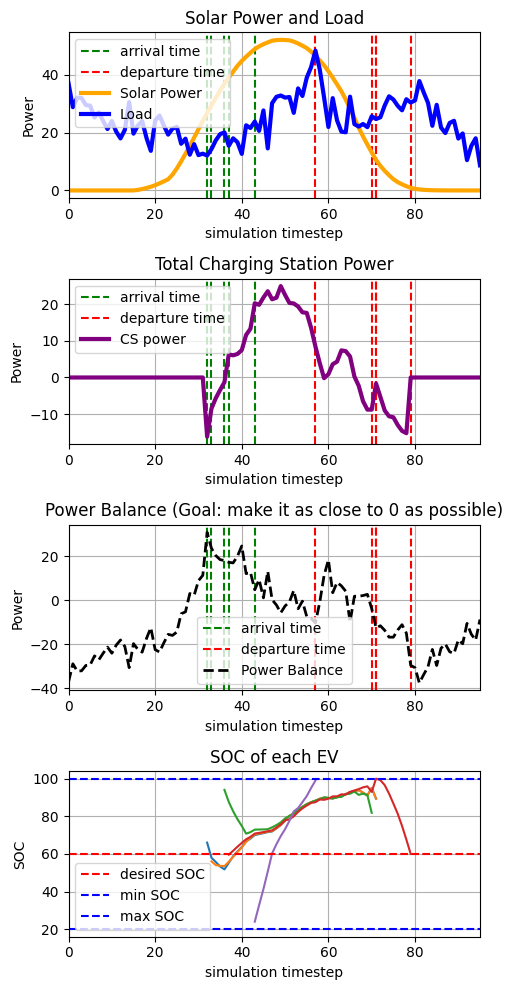

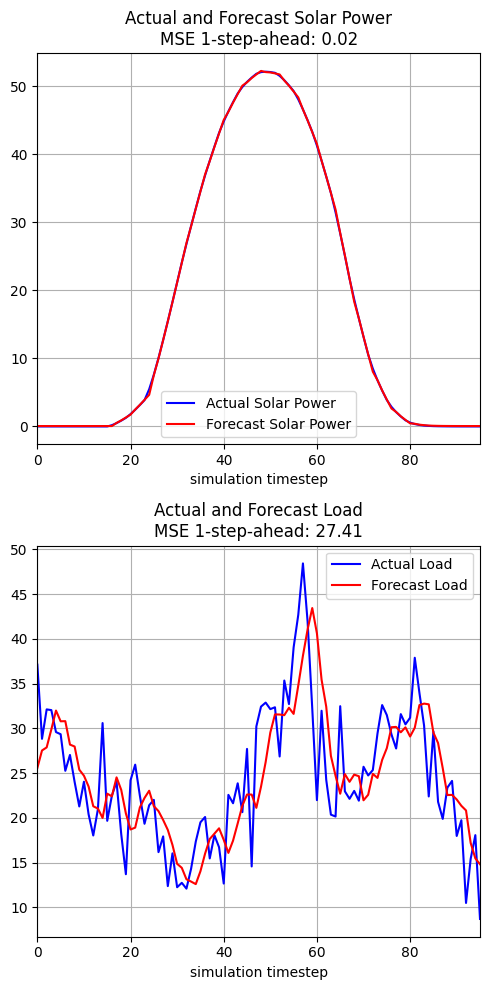

In [24]:
# all the codes below for plotting.

df_EV_SOC = pd.DataFrame()
df = pd.DataFrame(0, index= range(env.simulation_length), columns=['total_cs_power'])

# plotting

fig, axs = plt.subplots(4, 1, figsize=(5,10))  # 4 rows, 1 column

# plotting the SOC of EVs

for ev in env.EVs:
    soc = soc_evs[(ev.location, ev.time_of_arrival)]

    if ev.time_of_departure <= env.simulation_length:
        stay_time = range(ev.time_of_arrival, ev.time_of_departure + 1)
    else:
        stay_time = range(ev.time_of_arrival, env.simulation_length)

    axs[3].plot(stay_time, soc)

# plotting the arrival and departure time
for i, ev in enumerate(env.EVs):
    if i == 0:
        for i in range(3):
            axs[i].axvline(x= ev.time_of_arrival, color='green', label='arrival time', linestyle='--')
            axs[i].axvline(x = ev.time_of_departure, color='red', label='departure time', linestyle='--')
    else:
        for i in range(3):
            axs[i].axvline(x= ev.time_of_arrival, color='green', linestyle='--')
            axs[i].axvline(x = ev.time_of_departure, color='red', linestyle='--')


# plotting the CS power
for cs in env.charging_stations:
    df['total_cs_power'] += env.cs_power[cs.id, :]

df['solar_power'] = env.tr_solar_power[0, :] * -1
df ['inflexible_load'] = env.tr_inflexible_loads[0, :]
df["power_balance"] = df['solar_power'] - df ['inflexible_load'] - df['total_cs_power']

print("Sum power balance", sum(df["power_balance"]))

axs[0].plot(df.index, df['solar_power'], label='Solar Power', color='orange', linewidth = 3)
axs[0].plot(df.index, df['inflexible_load'], label='Load', color='blue', linewidth = 3)
axs[0].set_title("Solar Power and Load")

axs[1].plot(df.index, df['total_cs_power'], label='CS power', color='purple', linewidth = 3)
axs[1].set_title("Total Charging Station Power")

axs[2].plot(df.index, df['power_balance'], label='Power Balance', color='black', linewidth = 2, linestyle='--')
axs[2].set_title("Power Balance (Goal: make it as close to 0 as possible)")

axs[3].axhline(y= env.EVs[0].desired_capacity/env.EVs[0].battery_capacity * 100, label='desired SOC', color='red', linestyle='--')
axs[3].axhline(y= env.EVs[0].min_battery_capacity/env.EVs[0].battery_capacity * 100, label='min SOC', color='blue', linestyle='--')
axs[3].axhline(y= env.EVs[0].battery_capacity/env.EVs[0].battery_capacity * 100, label='max SOC', color='blue', linestyle='--')
axs[3].set_ylabel('SOC')
axs[3].set_title("SOC of each EV")


for i in range(4):
    axs[i].set_xlim(0,env.simulation_length-1)
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlabel('simulation timestep')

for i in range(3):
    axs[i].set_ylabel('Power')


plt.tight_layout()
plt.show()


# plot the forecast values to see the difference between the forecast and the actual values
fig_2, axs_2 = plt.subplots(2, 1, figsize=(5,10))

axs_2[0].plot(range(env.simulation_length), df['solar_power'], label='Actual Solar Power', color = 'blue')

axs_2[0].plot(range(env.simulation_length), forecast_solar_0, label='Forecast Solar Power', color = 'red')

#calculate mse
solar_one_step_ahead_error_mse = np.mean((df['solar_power'] - forecast_solar_0)**2)
axs_2[0].set_title("Actual and Forecast Solar Power\nMSE 1-step-ahead: {:.2f}".format(solar_one_step_ahead_error_mse))

axs_2[1].plot(range(env.simulation_length), df['inflexible_load'], label='Actual Load', color = 'blue')
axs_2[1].plot(range(env.simulation_length), forecast_load_0, label='Forecast Load', color = 'red')

#calculate mse
load_one_step_ahead_error_mse = np.mean((df['inflexible_load'] - forecast_load_0)**2)
axs_2[1].set_title("Actual and Forecast Load\nMSE 1-step-ahead: {:.2f}".format(load_one_step_ahead_error_mse))


for i in range(2):
    axs_2[i].set_xlim(0,env.simulation_length-1)
    axs_2[i].legend()
    axs_2[i].grid(True)
    axs_2[i].set_xlabel('simulation timestep')

plt.tight_layout()